In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

from statsmodels.regression.linear_model import OLS

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [3]:
random_seed = 1923
rng = np.random.default_rng(random_seed)

## Data generation

In [4]:
# Generating predictors: 10 in total, first 5 multicollinear, first 3 predictive
n_obs = 100

# Generate 5 columns of N(0, 1) data
x_mean = 0
x_sd = 1
x_random = rng.normal(x_mean, x_sd, size = (n_obs, 5))

# Generate 5 columns of multicollinear data
means = [0, 0, 0, 0, 0]
covariances = r = np.array([
        [1.0, 0.6, 0.8, 0.4, 0.7],
        [0.6, 1.0, 0.8, 0.6, 0.4],
        [0.8, 0.8, 1.0, 0.8, 0.8],
        [0.4, 0.6, 0.8, 1.0, 0.6],
        [0.7, 0.4, 0.8, 0.6, 1.0]
    ])
x_correlated = rng.multivariate_normal(means, covariances, size = n_obs)

# Combine them
x = np.concatenate([x_correlated, x_random], axis = 1)
x = pd.DataFrame(x)
xarray = xr.DataArray(x) # For plotting with arviz

In [5]:
# Check the correlation matrix of predictors
np.corrcoef(x_random, rowvar = False)

array([[ 1.        ,  0.06178445,  0.02751957, -0.15869338, -0.09388627],
       [ 0.06178445,  1.        ,  0.06173015, -0.0179062 , -0.19199826],
       [ 0.02751957,  0.06173015,  1.        ,  0.07580967, -0.18663197],
       [-0.15869338, -0.0179062 ,  0.07580967,  1.        ,  0.07693846],
       [-0.09388627, -0.19199826, -0.18663197,  0.07693846,  1.        ]])

In [6]:
# Check the correlation matrix of predictors
np.corrcoef(x_correlated, rowvar = False)

array([[1.        , 0.66838044, 0.79724243, 0.48437181, 0.6537348 ],
       [0.66838044, 1.        , 0.84808524, 0.72516445, 0.43040894],
       [0.79724243, 0.84808524, 1.        , 0.85951921, 0.78368936],
       [0.48437181, 0.72516445, 0.85951921, 1.        , 0.619859  ],
       [0.6537348 , 0.43040894, 0.78368936, 0.619859  , 1.        ]])

In [7]:
# Relationship & link function
true_intercept = 0.5
true_slopes = [0.9, -0.3, 0.4, 0, 0, 0, 0, 0, 0, 0] # Only the first 3 columns are actually predictive
true_line = true_intercept + x.dot(true_slopes)

# Target
noise_mean = 0
noise_sd = 1
noise = rng.normal(noise_mean, noise_sd, size = n_obs)
y = true_line + noise

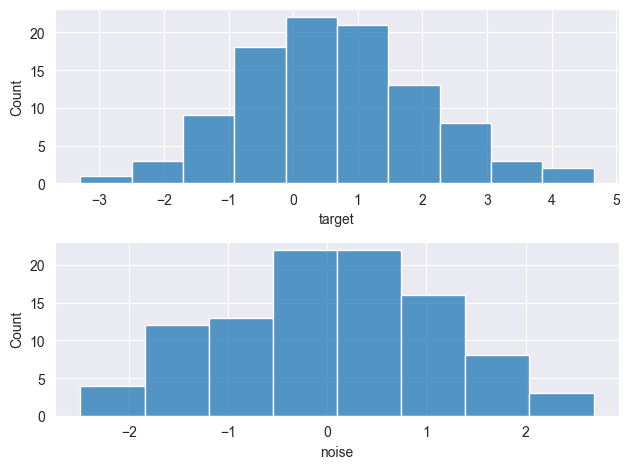

In [8]:
# Distributions of data
fig, ax = plt.subplots(2)

_ = sns.histplot(y, ax = ax[0])
_ = ax[0].set_xlabel("target")

_ = sns.histplot(noise, ax = ax[1])
_ = ax[1].set_xlabel("noise")

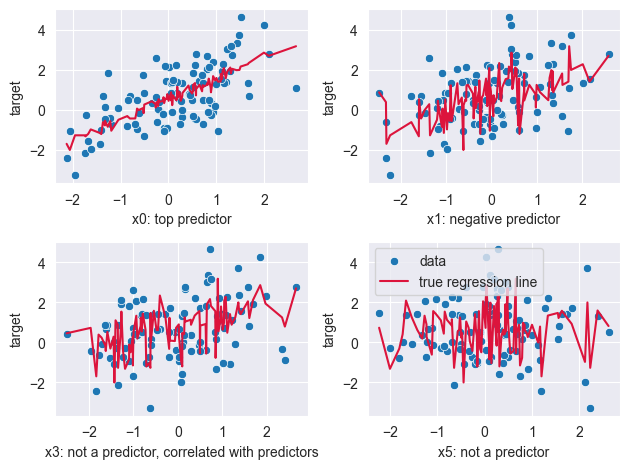

In [9]:
# True regression lines
fig, ax = plt.subplots(2, 2)

_ = sns.scatterplot(x = x[0], y = y, ax = ax[0, 0])
_ = sns.lineplot(x = x[0], y = true_line, color = "crimson", ax = ax[0, 0])
_ = ax[0, 0].set_xlabel("x0: top predictor")
_ = ax[0, 0].set_ylabel("target")

_ = sns.scatterplot(x = x[1], y = y, ax = ax[0, 1])
_ = sns.lineplot(x = x[1], y = true_line, color = "crimson", ax = ax[0, 1])
_ = ax[0, 1].set_xlabel("x1: negative predictor")
_ = ax[0, 1].set_ylabel("target")

_ = sns.scatterplot(x = x[3], y = y, ax = ax[1, 0])
_ = sns.lineplot(x = x[3], y = true_line, color = "crimson", ax = ax[1, 0])
_ = ax[1, 0].set_xlabel("x3: not a predictor, correlated with predictors")
_ = ax[1, 0].set_ylabel("target")

_ = sns.scatterplot(x = x[5], y = y, label = "data", ax = ax[1, 1])
_ = sns.lineplot(x = x[5], y = true_line, label = "true regression line", color = "crimson", ax = ax[1, 1])
_ = ax[1, 1].set_xlabel("x5: not a predictor")
_ = ax[1, 1].set_ylabel("target")

## Frequentist OLS

In [10]:
exog = x.copy()
exog["constant"] = np.ones(n_obs)

In [13]:
ols = OLS(endog = y, exog = exog)

In [14]:
ols_res = ols.fit()
ols_fitted = ols.predict(ols_res.params, exog)

In [15]:
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     7.939
Date:                Wed, 31 Jan 2024   Prob (F-statistic):           5.27e-09
Time:                        17:14:22   Log-Likelihood:                -148.28
No. Observations:                 100   AIC:                             318.6
Df Residuals:                      89   BIC:                             347.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.7662      0.255      3.001      0.003       0.259       1.273
1             -0.5889      0.305     -1.931      0.057      -1.195       0.017
2              1.2563      0.637      1.971      0.052      -0.010       2.523
3             -0.2652      0.291     -0.912      0.364      -0.843       0.313
4             -0.4370      0.258     -1.695      0.094      -0.949       0.075
5             -0.0380      0.119     -0.318      0.751      -0.275       0.199
6              0.1306      0.118      1.106      0.272      -0.104       0.365
7             -0.1000      0.118     -0.849      0.398      -0.334       0.134
8              0.0210      0.113      0.186      0.853      -0.203       0.245
9             -0.0588      0.115     -0.513      0.609      -0.286       0.169
constant       0.4893      0.120      4.084      0.000       0.251       0.727
==============================================================================
Omnibus:                        1.260   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.533   Jarque-Bera (JB):                1.332
Skew:                           0.248   Prob(JB):                        0.514
Kurtosis:                       2.729   Cond. No.                         13.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Very close intercept point estimate.
Actual predictor estimates bit off.
Correlated non-predictor estimates very off.
Non-predictor estimates decent.

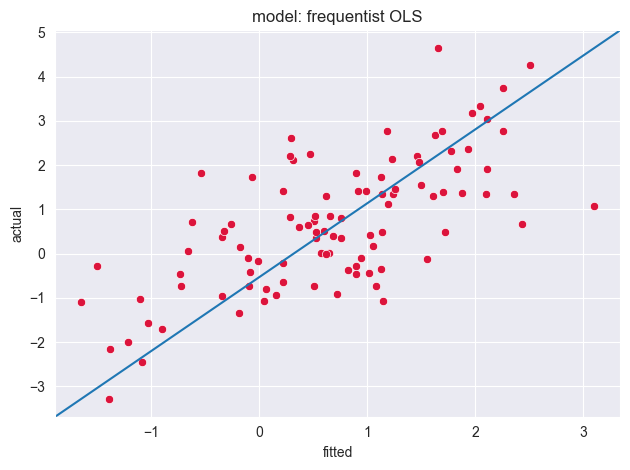

In [24]:
fig, ax = plt.subplots(1)
_ = sns.scatterplot(x = ols_fitted, y = y, color = "crimson", ax = ax)
_ = ax.plot([0, 1], [0, 1], transform=ax.transAxes)
_ = ax.set_xlabel("fitted")
_ = ax.set_ylabel("actual")
_ = ax.set_title("model: frequentist OLS")

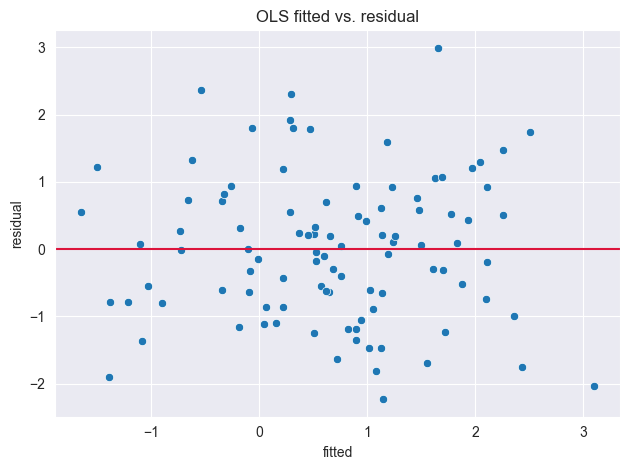

In [25]:
ols_resids = y - ols_fitted
_ = sns.scatterplot(x = ols_fitted, y = ols_resids)
_ = plt.axhline(0, c = "crimson")
_ = plt.title("OLS fitted vs. residual")
_ = plt.xlabel("fitted")
_ = plt.ylabel("residual")

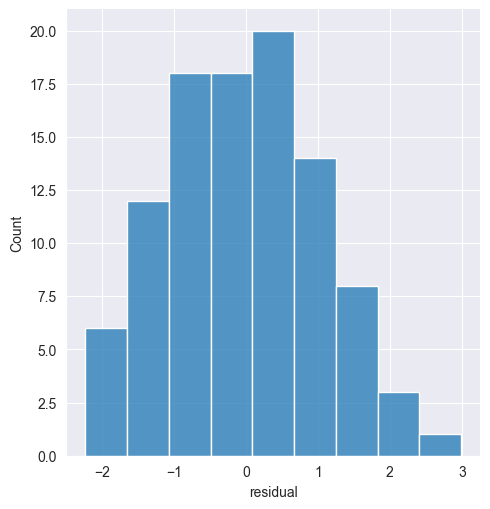

In [26]:
_ = sns.displot(ols_resids)
_ = plt.xlabel("residual")

## Flat prior

In [ ]:
# Tune the intercept prior
flat_prior_intercept_mu = 0
flat_prior_intercept_sd = 3
_ = sns.histplot(rng.normal(flat_prior_intercept_mu, flat_prior_intercept_sd, size = 1000))
_ = plt.axvline(true_intercept, c = "crimson")
_ = plt.xlabel("intercept prior, red = true value")

In [ ]:
# Tune the slope prior
flat_prior_slope_mu = 0
flat_prior_slope_sd = 3
_ = sns.histplot(rng.normal(flat_prior_slope_mu, flat_prior_slope_sd, size = 1000))
_ = plt.axvline(true_slope, c = "crimson")
_ = plt.xlabel("slope prior, red = true value")

Higher standard deviations for the flat priors could cause numerical issues, as the coefficients are in units of log(y).

In [ ]:
# Create model
flat_model = pm.Model()

In [ ]:
# Define priors & likelihood
with flat_model:

    # Flat priors for all parameters
    intercept = pm.Normal("intercept", mu = flat_prior_intercept_mu, sigma = flat_prior_intercept_sd) 
    slope = pm.Normal("slope", mu = flat_prior_slope_mu, sigma = flat_prior_slope_sd) 
    shape = pm.Uniform("shape", lower = 0, upper = 10)

    # Expected value & link
    mean = pm.math.exp(intercept + slope * x)
    rate = shape / mean

    # Likelihood
    likelihood = pm.Gamma(
        "outcome", 
        alpha = shape, 
        beta = rate, 
        observed = y)

In [ ]:
# Sample from the prior
with flat_model:
    flat_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

In [ ]:
# Prior predictive check
y_flat_prior = np.exp(flat_prior.prior["intercept"] + (flat_prior.prior["slope"] * xarray))
y_flat_prior = y_flat_prior.stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_flat_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

The flat prior allows for a very large range of predictions.

In [ ]:
# Draw posterior samples
with flat_model:
    flat_posterior = pm.sample(
    )

In [ ]:
# Sample from posterior
with flat_model:
    pm.sample_posterior_predictive(flat_posterior, extend_inferencedata = True, random_seed = rng)

In [ ]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    flat_posterior,
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope),
        ("shape", {}, true_shape)
    )
)

In [ ]:
# Parameter space plots
fig, ax = plt.subplots(2)

_ = az.plot_kde(
    az.extract(flat_posterior, var_names="intercept"),
    az.extract(flat_posterior, var_names="slope"),
    contourf_kwargs={"cmap": "Blues"},
    ax = ax[0]
)
_ = ax[0].plot(true_intercept, true_slope, "C2o", label="true parameters")
_ = ax[0].set_xlabel("intercept")
_ = ax[0].set_ylabel("slope")
_ = ax[0].legend()

_ = az.plot_kde(
    az.extract(flat_posterior, var_names="shape"),
    az.extract(flat_posterior, var_names="slope"),
    contourf_kwargs={"cmap": "Blues"},
    ax = ax[1]
)
_ = ax[1].plot(true_shape, true_slope, "C2o", label="true parameters")
_ = ax[1].set_xlabel("shape")
_ = ax[1].set_ylabel("slope")
_ = ax[1].legend()

Similar to OLS, the slope estimate is fairly easy with a narrow range of values, compared to the intercept which is troublesome. Probably because the slope has a much bigger effect due to the exponential nature of the linear predictor.

In [ ]:
# Simulate fitted regression lines
flat_fitted = (np.exp(flat_posterior.posterior["intercept"] + flat_posterior.posterior["slope"] * xarray))

In [ ]:
# Plot fitted vs. actual relationship

# Highest density interval for fitted regression lines
_ = az.plot_hdi(
    xarray,
    flat_fitted,
    fill_kwargs = {"alpha": 0.3, "label": "HDI 95%"},
    hdi_prob = .95
)

# Mean of fitted regression lines
_ = sns.lineplot(
    x = np.sort(x), 
    y = np.sort(flat_fitted.mean(("chain", "draw")).values), 
    label = "predictive mean", color = "C1")

# True regression line
_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")

# True observations
_ = sns.scatterplot(x = x, y = y, label = "observed data", color = "crimson")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

In [ ]:
# Plot posterior distribution
_ = az.plot_ppc(flat_posterior, num_pp_samples = 100)

Fitted relationship & posterior predictive distribution is pretty good for such a wide range of priors.

## Flat + regularized prior

In [ ]:
# Tune the intercept prior
prior_intercept_mu = 0.05
prior_intercept_sd = 0.1
_ = sns.histplot(rng.normal(prior_intercept_mu, prior_intercept_sd, size = 1000))
_ = plt.axvline(true_intercept, c = "crimson")
_ = plt.xlabel("intercept prior, red = true value")

In [ ]:
# Tune the slope prior
prior_slope_mu = 0.2
prior_slope_sd = 0.1
_ = sns.histplot(rng.normal(prior_slope_mu, prior_slope_sd, size = 1000))
_ = plt.axvline(true_slope, c = "crimson")
_ = plt.xlabel("slope prior, red = true value")

In [ ]:
# Tune the shape prior
prior_shape_mu = 4.75
prior_shape_sd = 0.5
_ = sns.histplot(rng.normal(prior_shape_mu, prior_shape_sd, size = 1000))
_ = plt.axvline(true_shape, c = "crimson")
_ = plt.xlabel("shape prior, red = true value")

In [ ]:
# Create model
informative_model = pm.Model()

In [ ]:
# Define priors & likelihood
with informative_model:

    # Informative priors for all parameters
    intercept = pm.Normal("intercept", mu = prior_intercept_mu, sigma = prior_intercept_sd)
    slope = pm.Normal("slope", mu = prior_slope_mu, sigma = prior_slope_sd)
    shape = pm.Normal("shape", mu = prior_shape_mu, sigma = prior_shape_sd )

    # Expected value & link
    mean = pm.math.exp(intercept + slope * x)
    rate = shape / mean

    # Likelihood
    likelihood = pm.Gamma(
        "outcome", 
        alpha = shape, 
        beta = rate, 
        observed = y)

In [ ]:
# Sample from the prior
with informative_model:
    informative_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

In [ ]:
# Prior predictive check
y_informative_prior = np.exp(informative_prior.prior["intercept"] + (informative_prior.prior["slope"] * xarray))
y_informative_prior = y_informative_prior.stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_informative_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

Much better prediction range enforced by priors, but still very large compared to actual values of y.

In [ ]:
# Draw posterior samples
with informative_model:
    informative_posterior = pm.sample()

In [ ]:
# Sample from posterior
with informative_model:
    pm.sample_posterior_predictive(informative_posterior, extend_inferencedata = True, random_seed = rng)

In [ ]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    informative_posterior,
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope),
        ("shape", {}, true_shape)
    )
)

In [ ]:
# Parameter space plots
fig, ax = plt.subplots(2)

_ = az.plot_kde(
    az.extract(informative_posterior, var_names="intercept"),
    az.extract(informative_posterior, var_names="slope"),
    contourf_kwargs={"cmap": "Blues"},
    ax = ax[0]
)
_ = ax[0].plot(true_intercept, true_slope, "C2o", label="true parameters")
_ = ax[0].set_xlabel("intercept")
_ = ax[0].set_ylabel("slope")
_ = ax[0].legend()

_ = az.plot_kde(
    az.extract(informative_posterior, var_names="shape"),
    az.extract(informative_posterior, var_names="slope"),
    contourf_kwargs={"cmap": "Blues"},
    ax = ax[1]
)
_ = ax[1].plot(true_shape, true_slope, "C2o", label="true parameters")
_ = ax[1].set_xlabel("shape")
_ = ax[1].set_ylabel("slope")
_ = ax[1].legend()

Much better intercept & slope estimates, but shape is not too good. Probably due to the small sample size & high variance.

In [ ]:
# Simulate fitted regression lines
informative_fitted = (np.exp(informative_posterior.posterior["intercept"] + informative_posterior.posterior["slope"] * xarray))

In [ ]:
# Plot fitted vs. actual relationship
_ = az.plot_hdi(
    xarray,
    informative_fitted,
    fill_kwargs = {"alpha": 0.3, "label": "HDI 95%"},
    hdi_prob = .95
)

_ = sns.lineplot(
    x = np.sort(x), 
    y = np.sort(informative_fitted.mean(("chain", "draw")).values), 
    label = "predictive mean", color = "C1")

_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")

_ = sns.scatterplot(x = x, y = y, label = "observed data", color = "crimson")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

In [ ]:
# Plot posterior distribution
_ = az.plot_ppc(informative_posterior, num_pp_samples = 100)

Posterior predictive distribution is very close to the actual relationship now. It gets more uncertain for sparser areas of the data, which is expected.